In [55]:
import os
import torch

import torch.nn as nn
import torchvision as tv
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

from torchsummary import summary

#torch.cuda.is_available()

In [22]:
class DatasetLoader(Dataset):
    def __init__(self, metadata, img_dir, transform=None):
        """
        Args:
            metadata (DataFrame): DataFrame containing image file names and labels.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.metadata = metadata
        self.img_dir = img_dir
        self.transform = transform
        # Create a mapping for class names to indices
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(metadata['dx'].unique())}

    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        #lesion_id, image_id, dx, dx_type, age, sex, localization
        img_name = os.path.join(self.img_dir, self.metadata.iloc[idx, 1] + '.jpg')
        image = Image.open(img_name)
        label_name = self.metadata.iloc[idx,2]
        label = self.class_to_idx[label_name]
        filename = self.metadata.iloc[idx, 1]
    
        if self.transform:
            image = self.transform(image)

        return image, label, filename

In [61]:
transform = tv.transforms.Compose([
    tv.transforms.Resize((64,64)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_path = './data/images/'
metadata_path = './data/HAM10000_metadata.csv'
metadata = pd.read_csv(metadata_path)
dataset = DatasetLoader(metadata=metadata, img_dir=img_path, transform=transform)


In [62]:
# Split the dataset 60-20-20
train_size = int(0.6 * len(dataset))
validation_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - validation_size
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Trying visualization


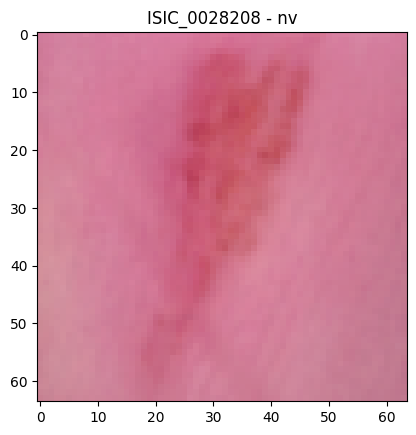

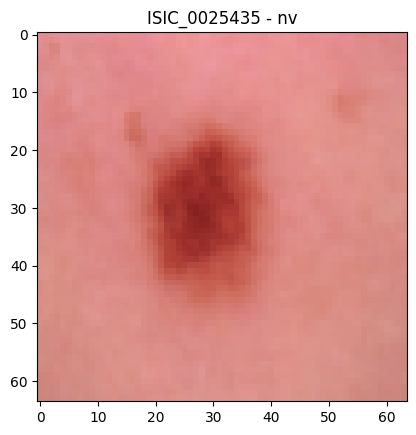

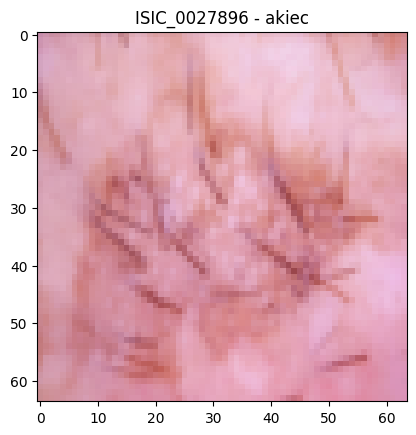

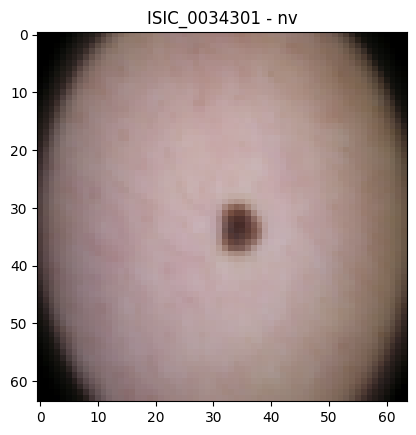

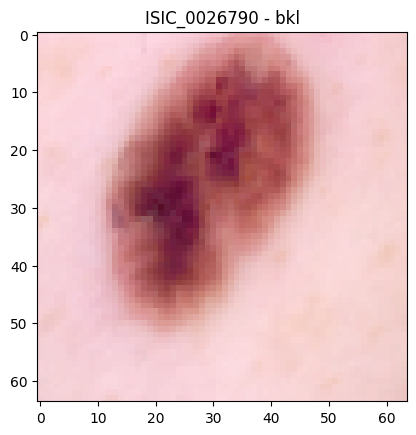

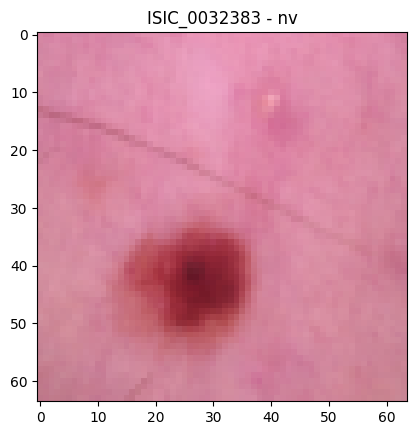

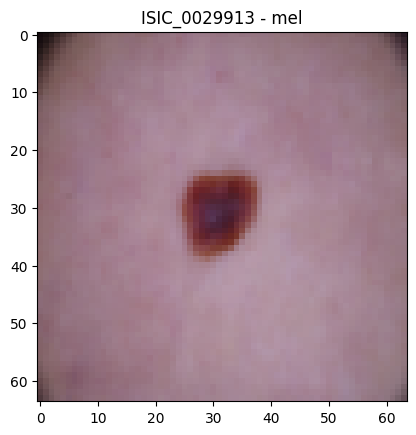

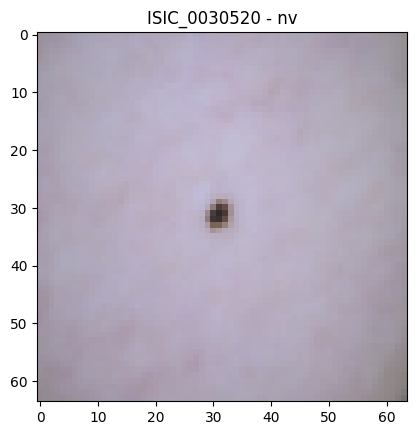

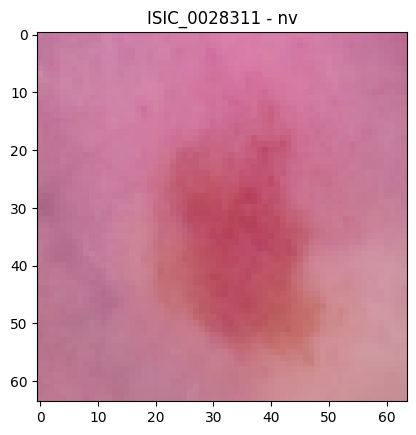

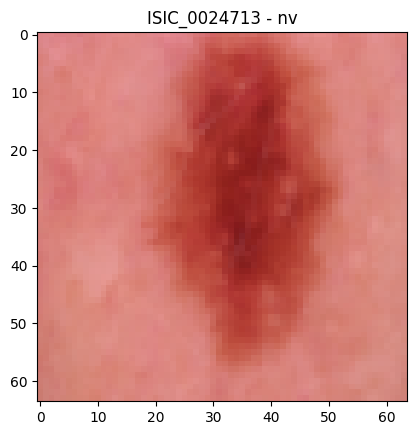

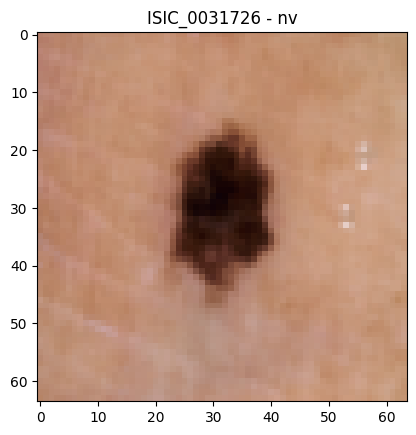

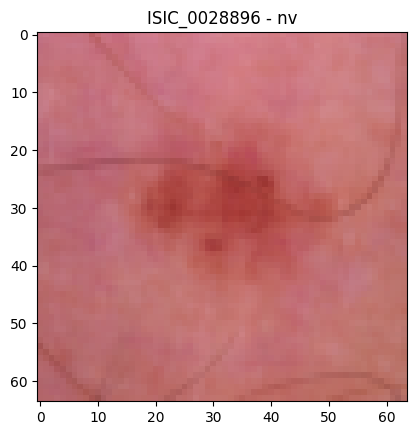

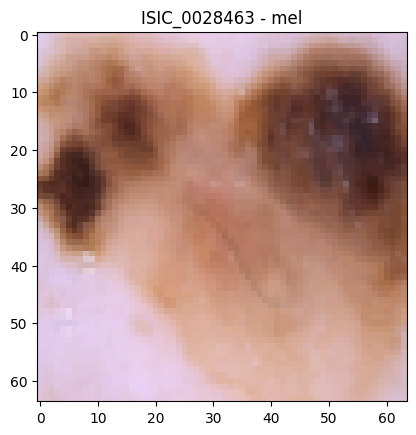

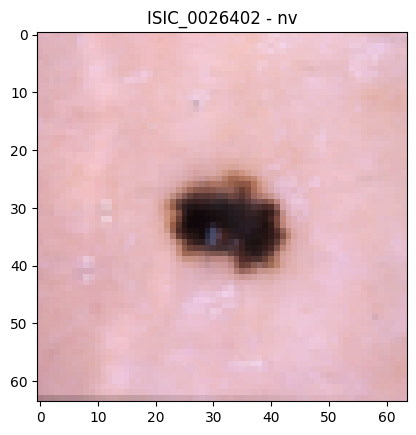

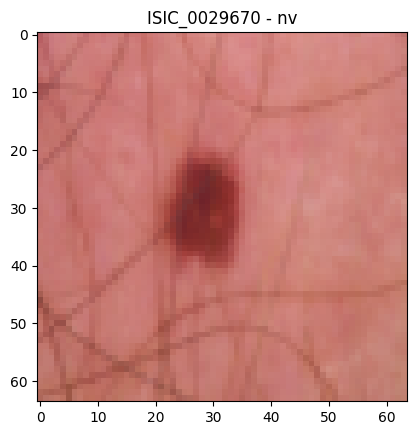

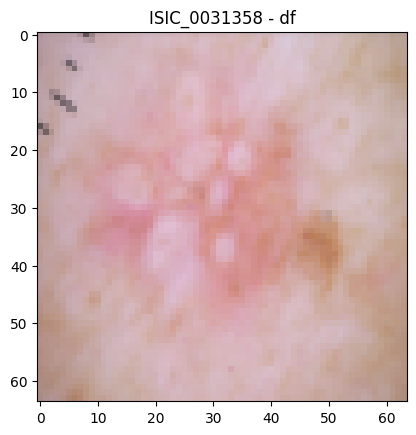

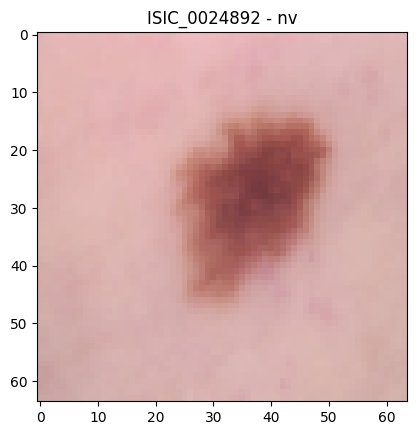

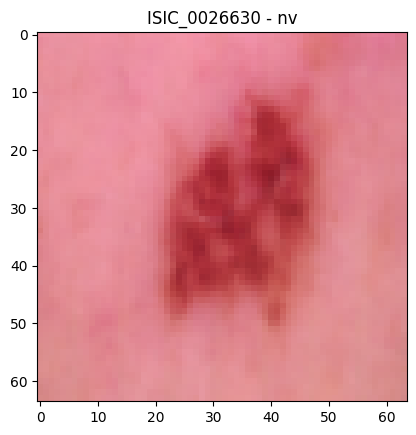

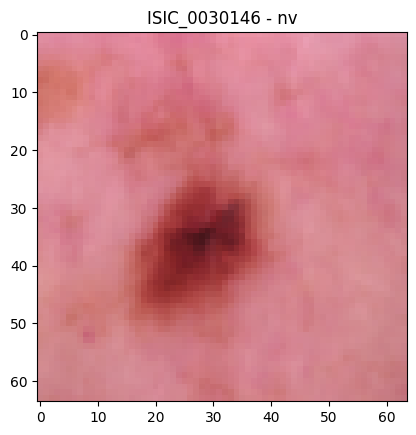

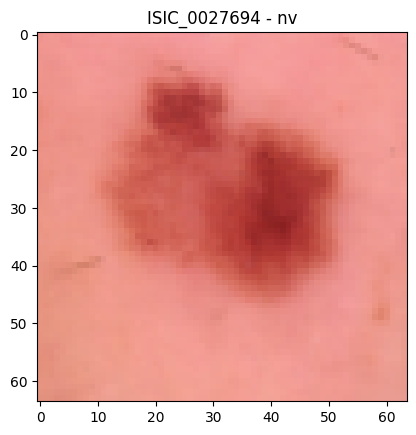

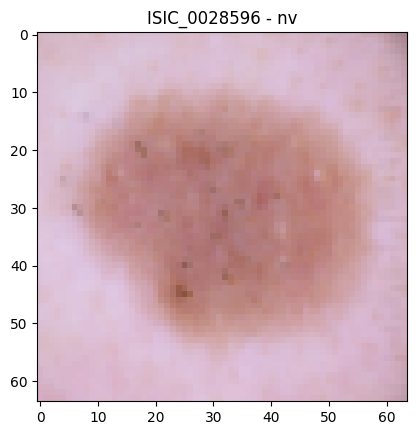

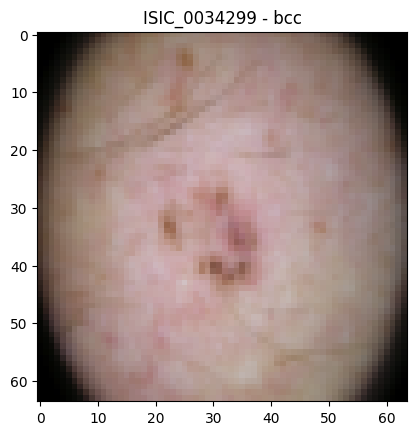

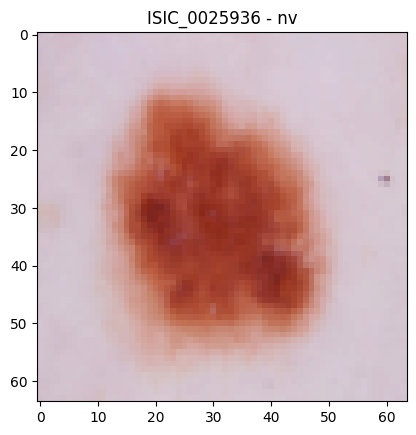

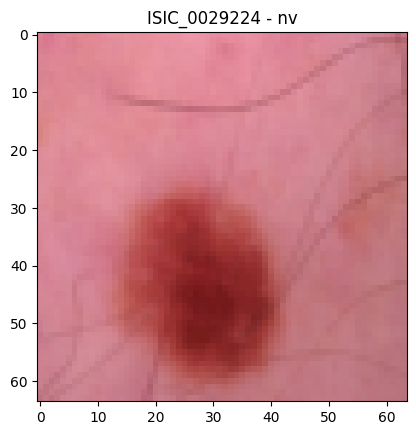

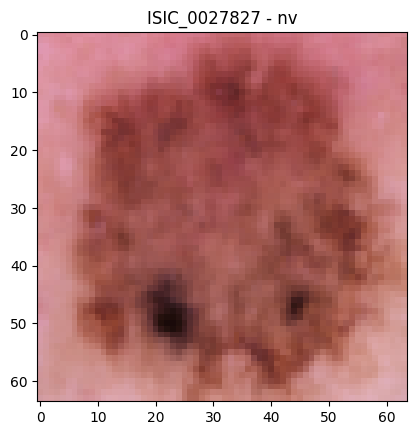

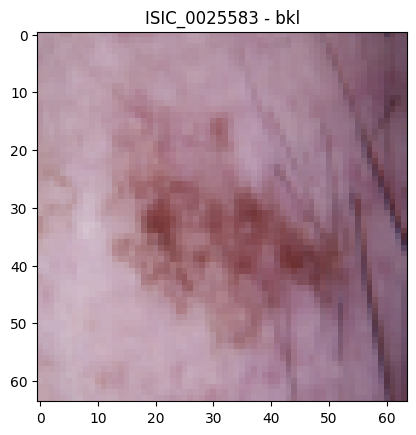

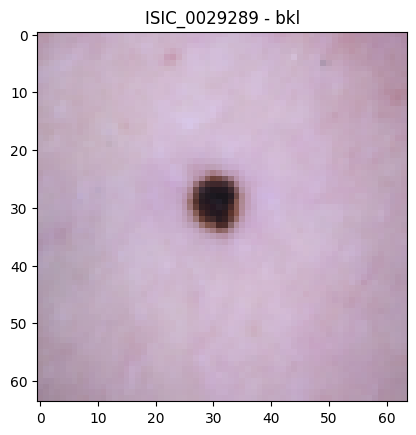

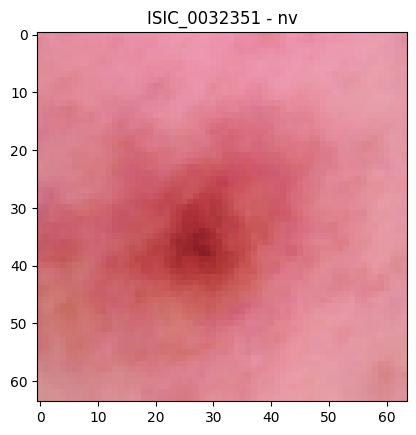

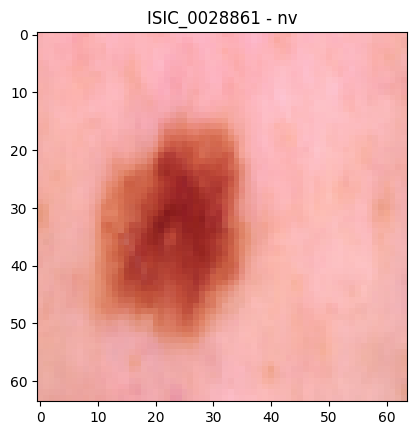

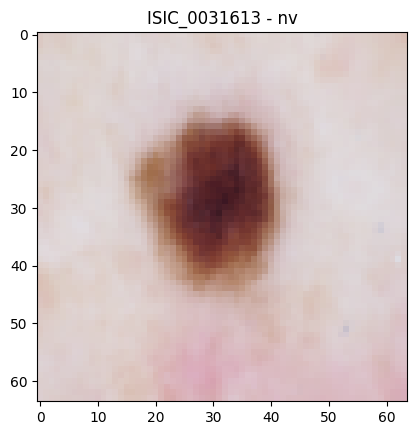

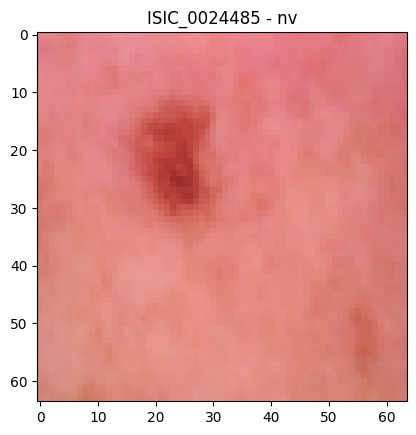

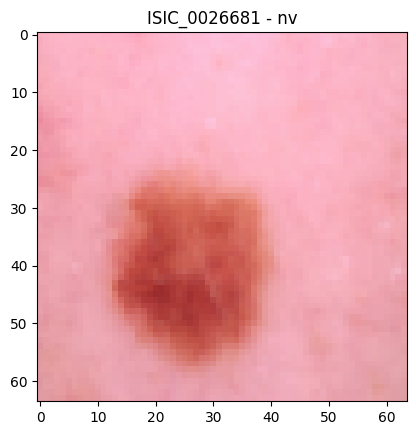

In [63]:
#Used ChatGPT to generate this code to make sure that the images are properly extracted

print("Trying visualization")

class_names = metadata['dx'].unique().tolist()

def imshow(inp, label, filename, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)  # Clip to the valid range [0,1]
    plt.imshow(inp)
    
    plt.title(f"{filename} - {class_names[label]}")
    plt.show()

# Get a batch of training data
inputs, classes, filenames = next(iter(train_loader))

# Visualize each image with its filename and label
for i in range(len(inputs)):
    imshow(inputs[i], classes[i], filenames[i])

In [77]:
class DCNN(nn.Module):

    def __init__(self):
        super(DCNN,self).__init__()

        #3 Pairs of convolution and max pool layers
        #Some reference tutorials: https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
        # as well as from the Pytorch documentation of each layer

        ##Assume input image of size 64x64
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1)
        self.maxpool2d_1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1)
        self.maxpool2d_2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1)
        self.maxpool2d_3 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(4608,512)
        self.fc2 = nn.Linear(512,7)

    # x represents our data
    def forward(self, x):
      
        x = self.conv1(x) #Input data first passed through conv1
        x = F.relu(x) #Then we pass it through RELU (introduce nonlinearity)
        x = self.maxpool2d_1(x) #Pass through maxpool 2D layer
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool2d_2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool2d_3(x)
        
        #x = torch.flatten(x,1)
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        
        x = F.log_softmax(x, dim=1)

        return x

        
        

In [79]:
# Step 1: Instantiate the model
model = DCNN()

summary(model,(3,64,64))
#assert False

#device = torch.device("cpu") #not "cuda"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move your model to GPU if cuda is available

# Step 2: Define a loss function
criterion = nn.CrossEntropyLoss()

# Step 3: Choose an optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)  # You can also try different learning rates

# Step 4: Training loop
num_epochs = 100  # Set the number of epochs

for epoch in range(num_epochs):
    print("Epoch: ",epoch)
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels, _ in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}')

    # Validation loop (optional, but recommended)
    model.eval()  # Set the model to evaluation mode
    validation_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, _ in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = validation_loss / len(validation_loader.dataset)
    val_accuracy = correct / total
    print(f'Validation Loss: {epoch_val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 62]             896
         MaxPool2d-2           [-1, 32, 31, 31]               0
            Conv2d-3           [-1, 64, 29, 29]          18,496
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5          [-1, 128, 12, 12]          73,856
         MaxPool2d-6            [-1, 128, 6, 6]               0
           Flatten-7                 [-1, 4608]               0
            Linear-8                  [-1, 512]       2,359,808
            Linear-9                    [-1, 7]           3,591
Total params: 2,456,647
Trainable params: 2,456,647
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.89
Params size (MB): 9.37
Estimated Total Size (MB): 11.31
--------------------------------------


KeyboardInterrupt



In [5]:
assert False

class RegNetYBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, groups=1):
        super(RegNetYBlock, self).__init__()
        # Assuming use of bottleneck blocks with a reduction at the beginning
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, kernel_size=3, stride=stride, padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out += identity
        out = F.relu(out)

        return out

class RegNetY320(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(RegNetY320, self).__init__()
        self.in_channels = 32  # Initial number of channels
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Example of layer configuration, actual values should be based on the RegNetY-320 config
        self.layer1 = self._make_layer(block, 64, layers[0], stride=2, groups=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, groups=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, groups=4)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, groups=8)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(512 * block.expansion, num_classes)
        # self.fc = nn.Linear(512 * block.expansion * 1 * 1, num_classes)
        # self.fc = nn.Linear(1024, num_classes)
        self.fc = nn.Linear(512, num_classes)  # Correct the input feature size here

        
    def _make_layer(self, block, out_channels, blocks, stride, groups):
        layers = [block(self.in_channels, out_channels, stride, groups)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, groups=groups))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        print("After initial conv and pool:", x.shape)

        x = self.layer1(x)
        print("After layer 1:", x.shape)
        x = self.layer2(x)
        print("After layer 2:", x.shape)
        x = self.layer3(x)
        print("After layer 3:", x.shape)
        x = self.layer4(x)
        print("After layer 4:", x.shape)

        x = self.avgpool(x)
        print("After adaptive average pool:", x.shape)
        x = torch.flatten(x, 1)
        print("After flatten:", x.shape)
        x = self.fc(x)
        print("After fc:", x.shape)

        return x


# Assuming "layers" is a list that contains the number of blocks in each stage
model = RegNetY320(RegNetYBlock, layers=[3, 4, 6, 3], num_classes=7)


In [6]:
assert False
# Step 1: Instantiate the model
# model = RegNetY320(...)  # Add your specific RegNetY-320 configuration here
device = torch.device("cuda")
model.to(device)  # Move your model to GPU if cuda is available

# Step 2: Define a loss function
criterion = nn.CrossEntropyLoss()

# Step 3: Choose an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # You can also try different learning rates

# Step 4: Training loop
num_epochs = 10  # Set the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels, _ in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}')

    # Validation loop (optional, but recommended)
    model.eval()  # Set the model to evaluation mode
    validation_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, _ in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = validation_loss / len(validation_loader.dataset)
    val_accuracy = correct / total
    print(f'Validation Loss: {epoch_val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

After initial conv and pool: torch.Size([32, 32, 64, 64])
After layer 1: torch.Size([32, 64, 32, 32])
After layer 2: torch.Size([32, 128, 16, 16])
After layer 3: torch.Size([32, 256, 8, 8])
After layer 4: torch.Size([32, 512, 4, 4])
After adaptive average pool: torch.Size([32, 512, 1, 1])
After flatten: torch.Size([32, 512])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x512 and 1024x7)